In [47]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
import collections
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_rel

In [2]:
dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table("pitchfork_reviews")

response = table.scan(
        FilterExpression=Attr('albumReleaseYear').lt(3000)
)

data = []
data.extend(response['Items'])

# get all data
while 'LastEvaluatedKey' in response:
  try:
    response = table.scan(
          ExclusiveStartKey=response['LastEvaluatedKey'],
          FilterExpression=Attr('albumReleaseYear').lt(3000)
    )
    data.extend(response['Items'])
  except:
    print("sleeping...")
    sleep(30)


In [3]:
df = pd.DataFrame(data)

In [25]:
df['publishYear'] = pd.DatetimeIndex(df['publishDate']).year
df['publishMonth'] = pd.DatetimeIndex(df['publishDate']).month
df['publishDay'] = pd.DatetimeIndex(df['publishDate']).dayofweek  #monday = 0, sunday = 6
df['yearDiff'] = df['publishYear'] - df['albumReleaseYear']
df

,albumName,albumReleaseYear,artistName,artistNameAlbumName,authorName,body,genre,publishDate,rating,title,url,viewCount,ytUrl,publishYear,publishMonth,publishDay,yearDiff
0,Summer Camp,2016,theMIND,theMIND - Summer Camp,Matthew Ramirez,"<p><a href=""http://pitchfork.com/artists/31057...",Rap,2016-08-12T05:00:00.000Z,7.0,Summer Camp,/reviews/albums/22240-summer-camp/,2,https://www.youtube.com/playlist?list=PLuVIIFx...,2016,8,4,0
1,Persuasion EP,2015,Blondes,Blondes - Persuasion EP,Cameron Cook,<p>With the current mainstream status and Coac...,Electronic,2015-08-11T06:00:04.000Z,7.3,Persuasion EP,/reviews/albums/20936-persuasion-ep/,393,https://www.youtube.com/playlist?list=PLWcUxVR...,2015,8,1,0
2,Head Off,2004,Moris Tepper,Moris Tepper - Head Off,Johnny Loftus,<p>Moris Tepper proves a chameleon on <em>Head...,Folk/Country,2004-09-22T06:00:04.000Z,7.5,Head Off,/reviews/albums/8272-head-off/,50214,https://www.youtube.com/playlist?list=PL049623...,2004,9,2,0
3,Our Land Brains,2002,Snowglobe,Snowglobe - Our Land Brains,Brad Haywood,"<p>In July of 2002, Bardot Records had the col...",Rock,2002-08-04T05:00:01.000Z,8.0,Our Land Brains,/reviews/albums/7307-our-land-brains/,9,https://www.youtube.com/playlist?list=PLKnOlRN...,2002,8,6,0
4,Weed Forestin',2012,Sentridoh,Sentridoh - Weed Forestin',Mark Richardson,"<p>In 1986 and 1987, a young dude in Massachus...",Rock,2012-03-16T06:00:00.000Z,8.2,Weed Forestin',/reviews/albums/16400-weed-forestin/,241,https://www.youtube.com/playlist?list=PL04tQ-W...,2012,3,4,0
5,Rivers Roll on By,2005,Jim and Jennie and the Pinetops,Jim and Jennie and the Pinetops - Rivers Roll ...,Joe Tangari,"<p>If you've ever been in a guitar shop, you k...",Folk/Country,2005-04-11T05:00:01.000Z,7.3,Rivers Roll on By,/reviews/albums/4255-rivers-roll-on-by/,164,https://www.youtube.com/playlist?list=PLmU2wGE...,2005,4,0,0
6,The Childhood of a Leader OST,2016,Scott Walker,Scott Walker - The Childhood of a Leader OST,Winston Cook-Wilson,"<p>To call <a href=""http://pitchfork.com/artis...",Rock,2016-08-22T05:00:00.000Z,7.9,The Childhood of a Leader OST,/reviews/albums/22248-the-childhood-of-a-leade...,10861,https://www.youtube.com/playlist?list=PL1d3BpW...,2016,8,0,0
7,Likes...,2004,Dani Siciliano,Dani Siciliano - Likes...,Scott Plagenhoef,<p>Even if you don't know Dani Siciliano's nam...,Jazz,2004-01-25T06:00:03.000Z,6.9,Likes...,/reviews/albums/7732-likes/,5183,https://www.youtube.com/playlist?list=PL60C23E...,2004,1,6,0
8,Eros in Arabia,1981,Richard Horowitz,Richard Horowitz - Eros in Arabia,Andy Beta,<p>When it came time for percussionist and com...,Experimental,2017-10-14T05:00:00.000Z,7.8,Eros in Arabia,/reviews/albums/richard-horowitz-eros-in-arabia/,194,https://www.youtube.com/playlist?list=PLR4OY1e...,2017,10,5,36
9,Reachy Prints,2014,Plaid,Plaid - Reachy Prints,Miles Raymer,<p>Plaid have been reliable fixtures in “intel...,Electronic,2014-05-23T06:00:05.000Z,6.0,Reachy Prints,/reviews/albums/19363-plaid-reachy-prints/,25540,https://www.youtube.com/playlist?list=PLH-RVxt...,2014,5,4,0


LinregressResult(slope=0.018344231537222252, intercept=-29.837197548424431, rvalue=0.068940995235880487, pvalue=9.7865934910307529e-19, stderr=0.0020732180357563475)


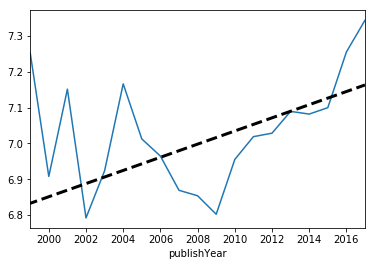

publishYear
1999    7.252632
2000    6.907831
2001    7.151376
2002    6.792109
2003    6.923596
2004    7.166219
2005    7.012488
2006    6.964683
2007    6.869179
2008    6.853942
2009    6.802290
2010    6.955256
2011    7.018857
2012    7.028571
2013    7.089357
2014    7.081885
2015    7.099723
2016    7.255181
2017    7.343731
Name: rating, dtype: float64

In [186]:
df['rating'] = df['rating'].astype(float) 
by_year = df.groupby('publishYear')
means = by_year.rating.agg('mean')
means.plot()
# add regression
reg = linregress(df.publishYear, df.rating)
print(reg)

x = np.arange(1998, 2018)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))
plt.show()
means

LinregressResult(slope=0.018344231537222252, intercept=-29.837197548424431, rvalue=0.068940995235880487, pvalue=9.7865934910307529e-19, stderr=0.0020732180357563475)


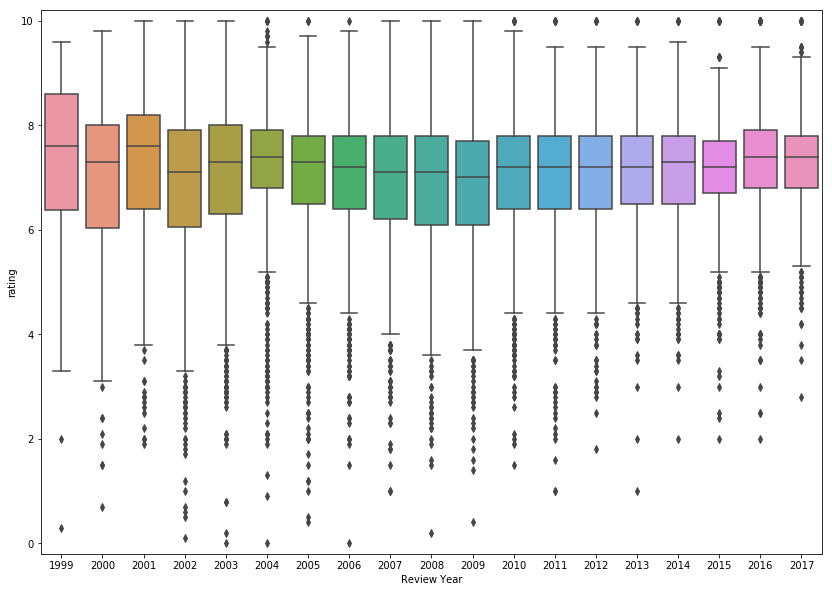

In [216]:
plt.clf()
plt.figure(figsize=(14, 10))


# add regression
reg = linregress(df.publishYear, df.rating)
print(reg)

x = np.arange(1998, 2018)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)), zorder=100)
sns.boxplot(x = 'publishYear', y = 'rating',  data = df, zorder=1)


plt.xlabel('Review Year')
plt.ylim([-0.2, 10.2])
plt.show()

LinregressResult(slope=0.050568405800316837, intercept=7.0059218850038461, rvalue=0.12019015223955135, pvalue=9.5321044988858267e-54, stderr=0.0032642734360381924)


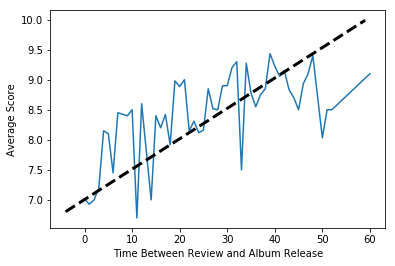

In [189]:
plt.clf()
df['yearDiff'] = df['yearDiff'].astype(float) 
zeroed = df[df['yearDiff'] >= 0]
yD = zeroed.groupby('yearDiff').rating.agg('mean')
plt.plot(yD.keys(), yD.values)

reg = linregress(zeroed['yearDiff'], zeroed.rating)
print(reg)

x = np.arange(-4, 60)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))


plt.xlabel('Time Between Review and Album Release')
plt.ylabel('Average Score')

plt.show()

LinregressResult(slope=0.0073482060422448278, intercept=6.9773550275678362, rvalue=0.019018786404125607, pvalue=0.014878190029589755, stderr=0.0030170152091357678)


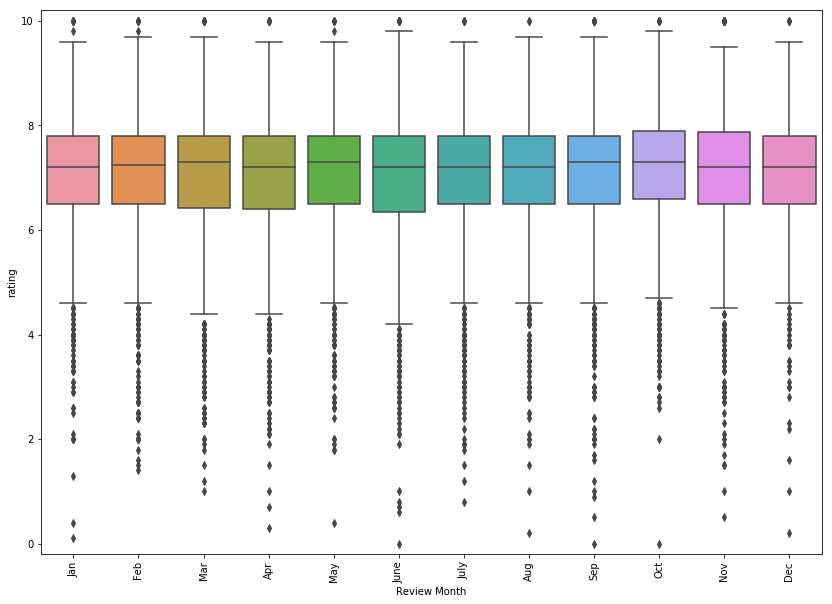

In [213]:
plt.clf()
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'publishMonth', y = 'rating',  data = df)

# add regression
reg = linregress(df.publishMonth, df.rating)
print(reg)

x = np.arange(-1, 13)
y = reg.intercept + x*reg.slope
#plt.plot(x,y,'--', color ='black', linewidth = 3,
#    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))

plt.xlabel('Review Month')
#plt.title('Rating by Review Month')
plt.ylim([-0.2, 10.2])
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 12), labels, rotation='vertical')
plt.show()

LinregressResult(slope=0.013668316893654159, intercept=6.9937646131261708, rvalue=0.017901686031836197, pvalue=0.021890430833121203, stderr=0.0059622342825067761)


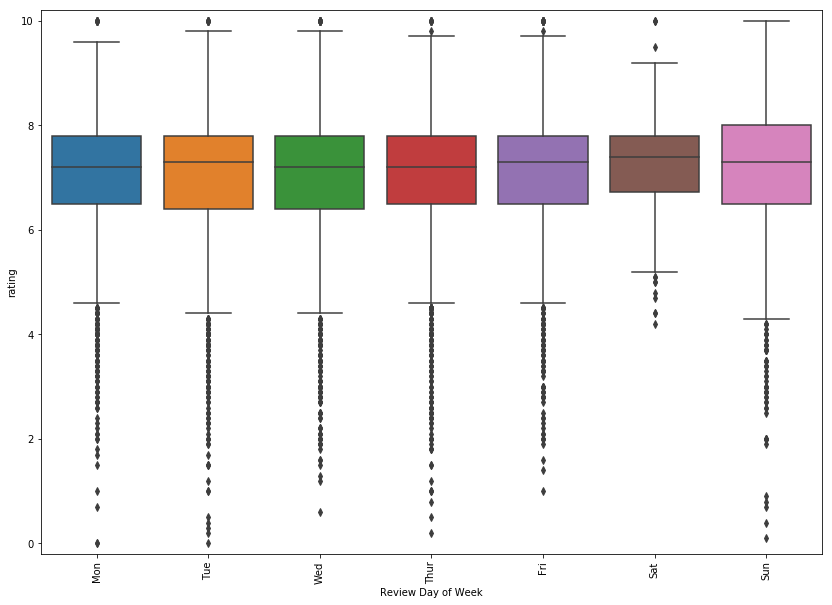

In [212]:
plt.clf()
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'publishDay', y = 'rating',  data = df)

# add regression
reg = linregress(df.publishDay, df.rating)
print(reg)

#x = np.arange(-1, 8)
#y = reg.intercept + x*reg.slope
#plt.plot(x,y,'--', color ='black', linewidth = 3,
#    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))

plt.xlabel('Review Day of Week')
#plt.title('Rating by Review Year')
plt.ylim([-0.2, 10.2])
labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
plt.xticks(np.arange(0, 7), labels, rotation='vertical')
plt.show()

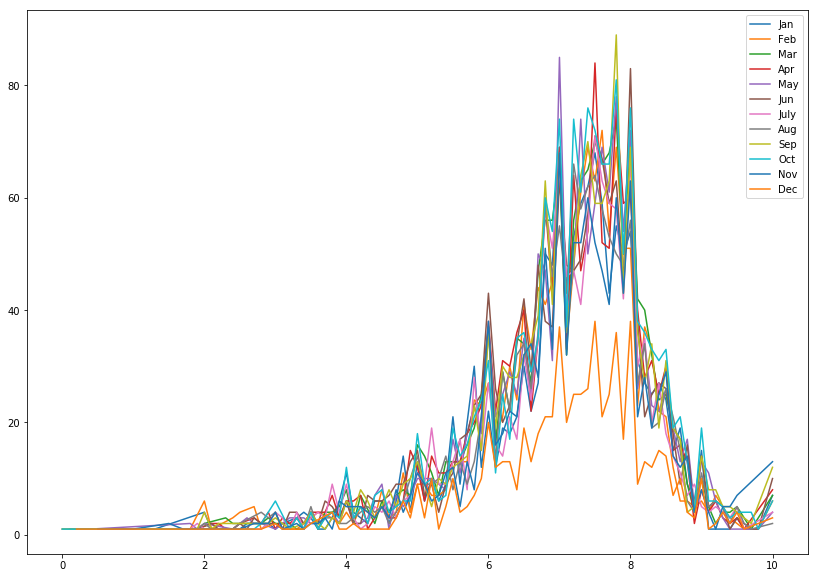

In [138]:
plt.clf()
plt.figure(figsize=(14, 10))

months =  df.groupby('publishMonth')
month_freq = months.rating.value_counts()
plt.plot(month_freq[1].sort_index(), label='Jan')
plt.plot(month_freq[2].sort_index(), label='Feb')
plt.plot(month_freq[3].sort_index(), label='Mar')
plt.plot(month_freq[4].sort_index(), label='Apr')
plt.plot(month_freq[5].sort_index(), label='May')
plt.plot(month_freq[6].sort_index(), label='Jun')
plt.plot(month_freq[7].sort_index(), label='July')
plt.plot(month_freq[8].sort_index(), label='Aug')
plt.plot(month_freq[9].sort_index(), label='Sep')
plt.plot(month_freq[10].sort_index(), label='Oct')
plt.plot(month_freq[11].sort_index(), label='Nov')
plt.plot(month_freq[12].sort_index(), label='Dec')

plt.legend(loc='best')
plt.show()

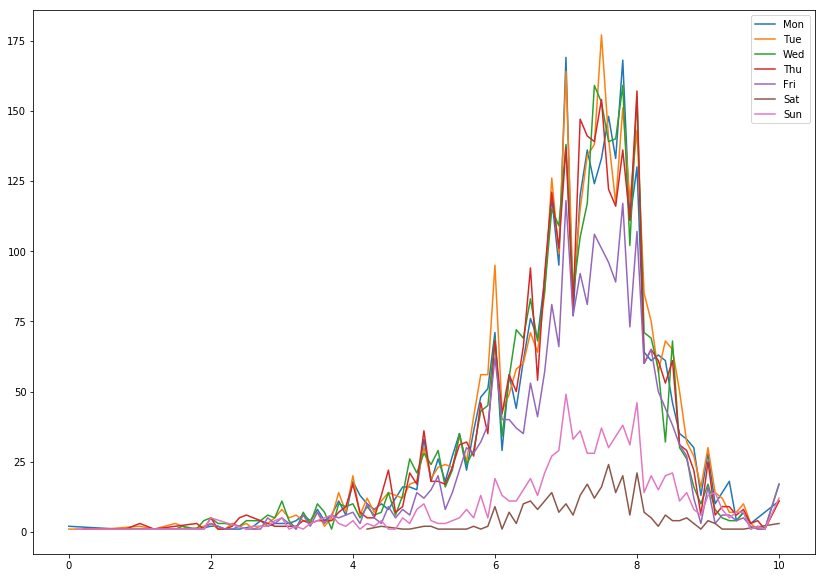

In [149]:
plt.clf()
plt.figure(figsize=(14, 10))

days =  df.groupby('publishDay')
day_freq = days.rating.value_counts()

plt.plot(day_freq[0].sort_index(), label='Mon')
plt.plot(day_freq[1].sort_index(), label='Tue')
plt.plot(day_freq[2].sort_index(), label='Wed')
plt.plot(day_freq[3].sort_index(), label='Thu')
plt.plot(day_freq[4].sort_index(), label='Fri')
plt.plot(day_freq[5].sort_index(), label='Sat')
plt.plot(day_freq[6].sort_index(), label='Sun')

plt.legend(loc='best')
plt.show()

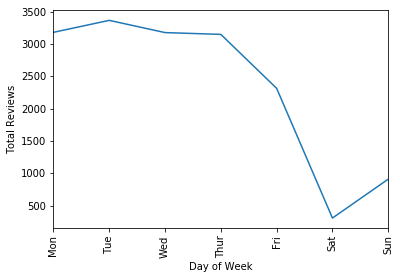

In [244]:
days =  df.groupby('publishDay')
daybar = days.artistNameAlbumName.agg('count')
daybar.plot()
plt.xlabel('Day of Week')
plt.ylabel('Total Reviews')
labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
plt.xticks(np.arange(0, 7), labels, rotation='vertical')
plt.show()

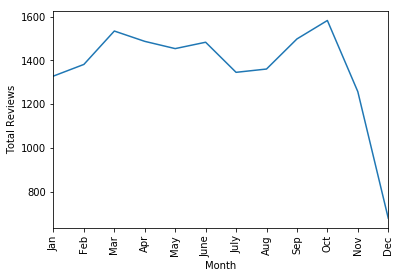

In [241]:
days =  df.groupby('publishMonth')
daybar = days.artistNameAlbumName.agg('count')
daybar.plot()
plt.xlabel('Month')
plt.ylabel('Total Reviews')
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(1, 13), labels, rotation='vertical')
plt.show()

In [223]:
months =  df.groupby(['publishMonth','genre'])
pd.set_option('display.max_rows',108)
months.rating.describe()

count      mean       std  min    25%   50%    75%  \
publishMonth genre                                                              
1            Electronic    321.0  6.895950  1.336980  0.4  6.400  7.10  7.800   
             Experimental  130.0  7.266154  1.166493  2.1  6.800  7.40  8.000   
             Folk/Country   49.0  7.328571  0.837904  5.4  7.000  7.40  7.900   
             Global         15.0  7.266667  1.110127  4.1  6.800  7.80  8.000   
             Jazz           20.0  7.440000  1.431378  3.5  6.900  7.65  8.175   
             Metal          52.0  7.159615  1.266655  3.8  6.475  7.50  8.000   
             Pop/R&B        92.0  6.896739  1.370927  0.1  6.100  7.25  7.800   
             Rap           142.0  6.873944  1.128715  3.5  6.425  7.00  7.500   
             Rock          508.0  7.004134  1.283011  2.0  6.400  7.20  7.800   
2            Electronic    328.0  6.986280  1.237893  2.0  6.475  7.20  7.800   
             Experimental  135.0  7.247407  1.245459  1.4  6.650  7.50  7.900   
             Folk/Country   61.0  7.304918  0.867453  5.2  6.700  7.30  7.900   
             Global         13.0  7.300000  1.233559  4.0  7.000  7.70  8.100   
             Jazz           21.0  7.242857  1.141303  3.3  6.900  7.50  7.800   
             Metal          61.0  7.060656  1.025391  2.5  6.700  7.30  7.800   
             Pop/R&B        77.0  6.816883  1.519211  2.0  6.300  7.10  7.800   
             Rap           100.0  6.912000  1.297805  1.6  6.475  7.20  7.800   
             Rock          586.0  6.916894  1.312740  1.8  6.300  7.20  7.700   
3            Electronic    387.0  6.901292  1.360784  1.0  6.400  7.10  7.800   
             Experimental  133.0  7.301504  1.054283  3.5  6.900  7.40  8.000   
             Folk/Country   69.0  7.314493  0.956291  3.9  6.900  7.40  8.000   
             Global         17.0  7.352941  1.116981  4.9  6.900  7.50  8.200   
             Jazz           28.0  7.800000  1.292141  4.0  7.175  7.75  8.725   
             Metal          81.0  7.161728  1.239210  1.9  6.800  7.50  8.000   
             Pop/R&B        92.0  6.800000  1.080700  3.9  6.200  7.00  7.525   
             Rap           130.0  6.956154  1.360632  2.4  6.300  7.25  7.800   
             Rock          597.0  6.980570  1.253702  2.3  6.400  7.20  7.800   
4            Electronic    356.0  6.885112  1.328804  1.5  6.200  7.20  7.725   
             Experimental  159.0  7.192453  1.208490  0.3  6.700  7.40  7.900   
             Folk/Country   56.0  7.050000  1.271792  2.3  6.450  7.30  7.825   
             Global         13.0  7.523077  0.825786  5.7  7.300  7.80  8.100   
             Jazz           16.0  7.793750  0.636101  6.7  7.300  7.90  8.050   
             Metal          57.0  7.003509  1.525376  2.2  6.200  7.60  8.000   
             Pop/R&B        98.0  7.194898  1.237921  3.5  6.400  7.35  7.975   
             Rap           119.0  7.020168  1.081084  2.4  6.450  7.10  7.800   
             Rock          613.0  6.886460  1.320810  0.7  6.300  7.20  7.800   
5            Electronic    309.0  6.984466  1.220769  1.8  6.500  7.20  7.800   
             Experimental  150.0  7.301333  0.981574  3.6  6.800  7.50  7.975   
             Folk/Country   78.0  7.147436  0.917326  4.7  6.700  7.40  7.700   
             Global         16.0  7.637500  0.532760  6.5  7.275  7.80  8.025   
             Jazz           20.0  7.285000  1.244472  3.4  6.925  7.25  8.325   
             Metal          74.0  6.694595  1.447046  1.9  6.000  7.00  7.775   
             Pop/R&B        91.0  7.186813  1.009093  4.1  6.800  7.30  7.850   
             Rap           116.0  7.088793  1.182832  2.0  6.400  7.20  7.900   
             Rock          600.0  7.013833  1.284085  0.4  6.400  7.20  7.900   
6            Electronic    363.0  6.859780  1.284021  1.9  6.100  7.00  7.750   
             Experimental  133.0  7.416541  0.906891  3.1  7.000  7.50  8.000   
             Folk/Country   64.0  7.237500  1.161895  2.7 